In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

In [2]:
torch.cuda.set_device(0)

In [3]:
PATH = os.path.abspath('../..')

# Helper methods for parsing and visualizing data

In [4]:
# note that these methods break if you use fastai v1.0
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by class_index           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

In [36]:
def load_image(idx, df, ax=None, use_SDSS=False, annotate=True):
    """Helper function to load and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    Z_pred, Z_true = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    if use_SDSS:
        image = plt.imread(f'{PATH}/test/{name}.jpg')
    else:
        image = plt.imread(f'{PATH}/ps1-test/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        #ax.text(0.5, 0.9, f'{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$Z_{\rm true}$' + f' = {Z_true:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$Z_{\rm pred}$' + f' = {Z_pred:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')

In [6]:
# basically the figure that I made in my paper
def plot_comparison_with_marginals(y_test, p_test):
    
    gs = matplotlib.gridspec.GridSpec(20, 20)
    
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(gs[4:, 2:18])
    
    # plot main histogram
    *_, im = ax.hist2d(y_test, p_test, bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=1)
    ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
    
    ax.set_xlabel(r'$Z_{\rm true}$', fontsize=18)
    ax.set_ylabel(r'$Z_{\rm pred}$', fontsize=18)
        
    # add colorbar
    ax_cb = fig.add_subplot(gs[4:, 19:])
    cb = fig.colorbar(im, cax=ax_cb);
    cb.set_label('Number', fontsize=14)
    
    # add top margin plot
    ax_marg = fig.add_subplot(gs[:4, 2:18])

    y_bins = np.linspace(8.3, 9.2, 10)
    rmse_bins = [np.sqrt(np.mean(((p_test - y_test)[(y_test > y - 0.05) & (y_test < y + 0.05)])**2)) for y in y_bins]
    num_in_bins = np.sum([(y_test > y - 0.05) & (y_test < y + 0.05) for y in y_bins], axis=1)
    rmse_error = rmse_np(p_test, y_test)
    ax_marg.scatter(y_bins, rmse_bins, marker='o', c='C0', s=num_in_bins/30, label=f'<RMSE>={rmse_error:.4f}')

    nmad_bins = [np.sqrt(nmad(((p_test - y_test)[(y_test > y - 0.05) & (y_test < y + 0.05)])**2)) for y in y_bins]
    nmad_error = nmad(p_test - y_test)
    ax_marg.scatter(y_bins, nmad_bins, marker='o', c='C1', s=num_in_bins/30, label=f'<NMAD>={nmad_error:.4f}')
    
    ax_marg.set_ylabel('Scatter', fontsize=14)
    ax_marg.legend(fontsize=12, framealpha=0.0, frameon=False)
    ax_marg.set_ylim(0, 0.3)
    ax_marg.set_xlim(8.2, 9.3)
    ax_marg.set_xticklabels([])
    
    # include mean RMSE  
    ax_marg.axhline(rmse_error, ls='-', c='C0')
    ax_marg.axhline(nmad_error, ls='-', c='C1')
        
def rmse_np(x, y):
    return np.sqrt(np.mean((y - x)**2))

def nmad(z, const=1.4826):
    """Returns the Gaussian sigma according to MAD"""
    return const*np.median(np.abs(z - np.median(z)))

# Constructing a learner

In [7]:
train_label_csv = f'{PATH}/catalogs/train-oh_p50.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)


In [14]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'ps1-train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='ps1-test', num_workers=16)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

In [15]:
# params
sz = 128
bs = 128
arch = resnet34

In [16]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

# Load SDSS pre-trained network

In [17]:
learn.load(f'resnet34-single_sz{sz}-bs{bs}-postsubmission')

# Predict

In [18]:
Z_pred, _ = learn.TTA(is_test=True)
Z_pred = Z_pred.mean(axis=0)

Compare with answer key

In [19]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)

df_test = pd.read_csv(f'{PATH}/catalogs/test-oh_p50.csv', index_col=0)
y_test = df_test.loc[test_names].values

In [25]:
Z_pred.shape, y_test.shape

((20465, 1), (20465, 1))

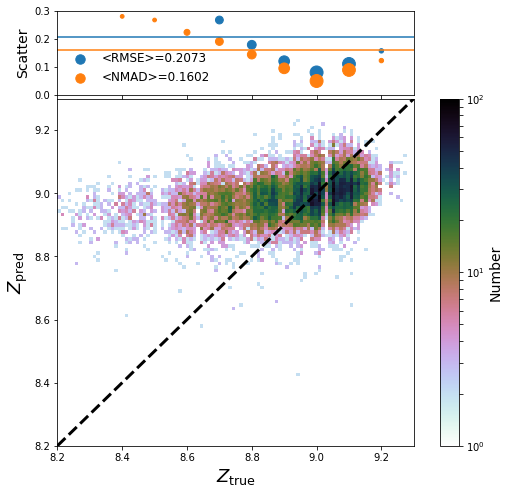

In [26]:
plot_comparison_with_marginals(y_test.flatten(), Z_pred.flatten())

# LOL

In [30]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)

preds = pd.DataFrame({'Z_pred': Z_pred.flatten(), 'Z_true': y_test.flatten()}, index=test_names)

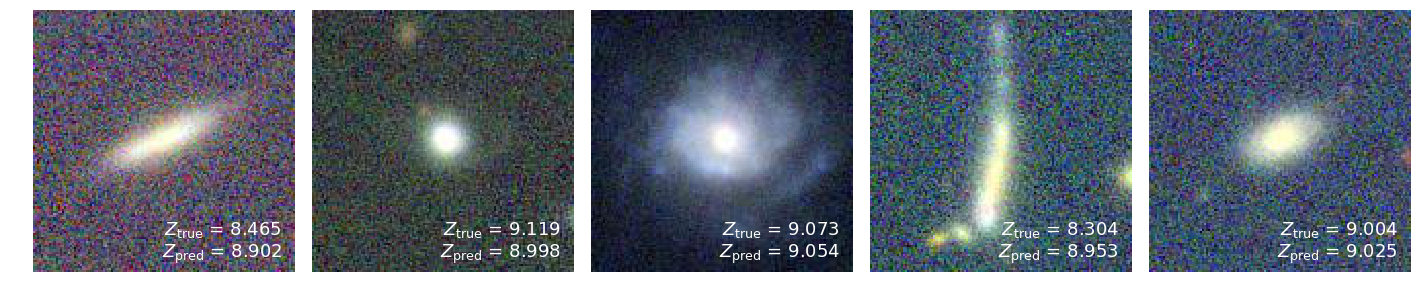

In [41]:
rand = preds.sample(frac=1., random_state=123)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

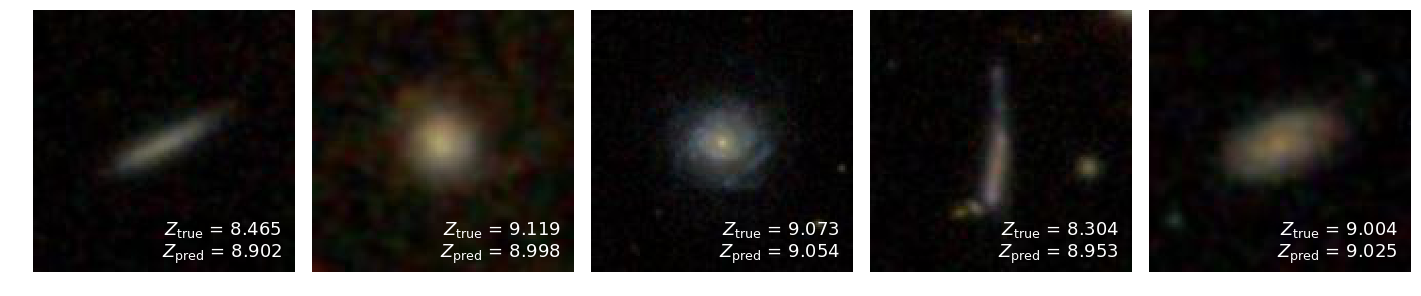

In [42]:
rand = preds.sample(frac=1., random_state=123)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax, use_SDSS=True)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)

# Some basic training

In [44]:
learn.lr_find()
learn.sched.plot()

 11%|█▏        | 136/1200 [00:13<01:49,  9.75it/s, loss=0.202]

OSError: No such file or directory: /home/jw740/projects/galaxy-cnns/ps1-train/1237671266574336118.jpg

 11%|█▏        | 136/1200 [00:30<03:54,  4.53it/s, loss=0.202]

In [43]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

## Train fully connected layers